# Nov 23, 2024: group align individual level estimates (partition modes)

the below script is run by the .py and .sh files

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
import random

import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'ses'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
def collect_indiv_dfs(args, indiv_files):
    # individual estimates, per animal
    indiv_dfs = []
    for indiv_file in tqdm(indiv_files):
        with open(indiv_file, 'rb') as f:
            indiv_df = pickle.load(f)
        sub = indiv_file.split('/')[-3].split('-')[-1]
        indiv_df['sub'] = [sub]*len(indiv_df)
        cols = list(indiv_df.columns)
        reordered_cols = [cols[-1]] + cols[:-1]
        indiv_df = indiv_df.reindex(columns=reordered_cols)
        indiv_dfs += [indiv_df]
        # break
    indiv_dfs = pd.concat(indiv_dfs).reset_index(drop=True)
    return indiv_dfs

In [6]:
def nested_partitions(g, b):
    b = gt.nested_partition_clear_null(b)
    state = gt.NestedBlockState(g, bs=[g.new_vp("int", vals=b[0])] + b[1:])
    state = state.copy(bs=b)
    bs = []
    for l, bl in enumerate(b):
        bl_ = np.array(state.project_level(l).get_state().a)
        bs.append(bl_)
        if len(np.unique(bl_)) == 1: break
    return bs

def project_partitions_on_graph(args, mode, max_level=-1):
    proj_bs = []
    for bs in tqdm(list(mode.get_nested_partitions().values())):
        proj_bs += [nested_partitions(g, bs)]
    max_level = np.max([len(bs) for bs in proj_bs]) if max_level == -1 else max_level
    level_bs = [[] for _ in range(max_level)]
    for bs in proj_bs:
        for level in range(max_level):
            level_bs[level] += [bs[level] if len(bs) > level else [0]*len(bs[0])]
    return level_bs, max_level

def align_nested_mode_to_pmode(args, mode, pmode_level_bs, pmode_max_level):
    mode_level_bs, mode_max_level = project_partitions_on_graph(args, mode, max_level=pmode_max_level)
    
    gmodes = []
    for level in tqdm(range(pmode_max_level)):
        gmode = gt.PartitionModeState(mode_level_bs[level], relabel=False, nested=False, converge=True)
        pmode_level = gt.PartitionModeState(pmode_level_bs[level], relabel=False, nested=False, converge=False)
        gmode.align_mode(pmode_level)
        gmodes += [gmode]
    
    return gmodes

def get_pi_matrix(args, mrgnls):
    num_comms = np.max([len(mrgnl) for mrgnl in mrgnls])
    pi = np.zeros((len(mrgnls), num_comms))

    for idx_node, mrgnl in enumerate(mrgnls):
        mrgnl = np.array(mrgnl)
        pi[idx_node, np.where(mrgnl)[0]] = mrgnl[mrgnl > 0]

    pi = pi / np.expand_dims(pi.sum(axis=-1), axis=-1)
    return pi # marginals matrix

def get_nested_marginals(args, g, level_modes):
    marginals = [list(level_mode.get_marginal(g)) for level_mode in level_modes]
    pis = {}
    for level, mrgnls in enumerate(marginals):
        pis[level] = get_pi_matrix(args, mrgnls)
    return pis

def collect_marginals_single_mode(args, row, pi):
    df = pd.DataFrame()
    df['sub'] = [row['sub']]
    df['mode_id'] = [row['mode_id']]
    df['pi'] = [pi]
    df['omega'] = [row['omega']]
    df['sigma'] = [row['sigma']]
    df['ratio'] = [row['ratio']]
    return df

def collect_nested_marginals_single_mode(args, row, pis):
    dfs = []
    for level, pi in pis.items():
        df = pd.DataFrame()
        df['sub'] = [row['sub']]
        df['mode_id'] = [row['mode_id']]
        df['level'] = [level]
        df['pi'] = [pi]
        df['omega'] = [row['omega']]
        df['sigma'] = [row['sigma']]
        df['ratio'] = [row['ratio']]
        dfs += [df]

    dfs = pd.concat(dfs).reset_index(drop=True)
    return dfs

In [7]:
def post_align_modes(args, indiv_dfs):
    pmode = gt.PartitionModeState(indiv_dfs['b_hat'].to_list(), nested=args.nested, converge=True)
    pmode_level_bs, pmode_max_level = project_partitions_on_graph(args, pmode)

    if args.sbm in ['h']:
        indiv_marginals_dfs = []
        for idx, row in indiv_dfs.iterrows():
            mode = row['mode']
            aligned_level_modes = align_nested_mode_to_pmode(args, mode, pmode_level_bs, pmode_max_level)
            pis = get_nested_marginals(args, g, aligned_level_modes)
            marginal_df = collect_nested_marginals_single_mode(args, row, pis)
            indiv_marginals_dfs += [marginal_df]
            # break
        indiv_marginals_dfs = pd.concat(indiv_marginals_dfs).reset_index(drop=True)

    if args.sbm in ['a', 'd']:
        indiv_marginals_dfs = []
        for idx, row in tqdm(indiv_dfs.iterrows()):
            mode = row['mode']
            mode.align_mode(pmode) # align to the group 
            mrgnls = list(mode.get_marginal(g))
            pi = get_pi_matrix(args, mrgnls)
            df = collect_marginals_single_mode(args, row, pi)
            indiv_marginals_dfs += [df]
            # break
        indiv_marginals_dfs = pd.concat(indiv_marginals_dfs).reset_index(drop=True)
    
    return indiv_marginals_dfs
    

In [8]:
sbms_list = [
    (True, 'a'),
    (True, 'd'),
    (True, 'h'),
    (False, 'd'),
    (False, 'h'),
]

In [9]:
graph_file = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(graph_file)
g

<Graph object, undirected, with 162 vertices and 2608 edges, 1 internal edge property, at 0x7f95c1ba1fd0>

In [10]:
for sbm in sbms_list[1:2]:    
    args.dc, args.sbm = sbm

    args.nested = args.sbm == 'h'

    args.force_niter = 40000
    args.num_draws = int((1/2) * args.force_niter)

    def sbm_name(args):
        dc = f'dc' if args.dc else f'nd'
        dc = f'' if args.sbm in ['a'] else dc
        file = f'sbm-{dc}-{args.sbm}'
        return file

    SBM = sbm_name(args)
    print(SBM)

    indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes/{SBM}_desc-df.pkl', recursive=True))

    indiv_dfs = collect_indiv_dfs(args, indiv_files)

    # indiv_marginals_dfs = post_align_modes(args, indiv_dfs)

# UNCOMMENT AFTER REMOVING TESTING CODE BELOW
    # for sub in tqdm(indiv_marginals_dfs['sub'].unique()):
    #     folder = f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}'
    #     os.system(f'mkdir -p {folder}')
    #     with open(f'{folder}/desc-marginals-df.pkl', 'wb') as f:
    #         pickle.dump(indiv_marginals_dfs[indiv_marginals_dfs['sub'] == sub], f)
        # break

sbm-dc-d


100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


---

In [12]:
def get_pi_matrix(args, mrgnls):
    num_comms = np.max([len(mrgnl) for mrgnl in mrgnls])
    pi = np.zeros((len(mrgnls), num_comms))

    for idx_node, mrgnl in enumerate(mrgnls):
        mrgnl = np.array(mrgnl)
        pi[idx_node, np.where(mrgnl)[0]] = mrgnl[mrgnl > 0]

    pi = pi / np.expand_dims(pi.sum(axis=-1), axis=-1)
    return pi # marginals matrix

In [14]:
indiv_dfs['pi'] = indiv_dfs['mode'].apply(lambda mode: get_pi_matrix(args, mode.get_marginal(g)))

In [15]:
indiv_dfs

,sub,mode_id,mode,b_hat,omega,sigma,ratio,pi
0,SLC01,0,<graph_tool.inference.partition_modes.Partitio...,"[0, 1, 1, 2, 3, 0, 1, 0, 4, 4, 0, 1, 5, 2, 0, ...",0.210,0.052,4.038,"[[0.0, 0.0, 0.9939759036144579, 0.0, 0.0, 0.0,..."
1,SLC01,1,<graph_tool.inference.partition_modes.Partitio...,"[5, 14, 1, 8, 2, 0, 1, 15, 4, 4, 0, 1, 5, 15, ...",0.123,0.124,0.992,"[[0.0, 0.0, 0.0010822510822510823, 0.0, 0.0, 0..."
2,SLC01,2,<graph_tool.inference.partition_modes.Partitio...,"[0, 4, 9, 0, 15, 0, 4, 0, 5, 4, 0, 9, 5, 0, 0,...",0.123,0.091,1.352,"[[0.0, 0.0, 0.7624458874458875, 0.0, 0.0, 0.00..."
3,SLC01,3,<graph_tool.inference.partition_modes.Partitio...,"[0, 14, 9, 0, 15, 0, 14, 0, 5, 14, 0, 9, 5, 0,...",0.115,0.108,1.065,"[[0.0, 0.0005793742757821553, 0.59907300115874..."
4,SLC01,4,<graph_tool.inference.partition_modes.Partitio...,"[5, 14, 1, 8, 2, 0, 4, 15, 4, 4, 0, 1, 5, 15, ...",0.109,0.129,0.845,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...
96,SLC10,3,<graph_tool.inference.partition_modes.Partitio...,"[0, 5, 5, 0, 3, 0, 5, 0, 0, 5, 4, 5, 0, 0, 0, ...",0.077,0.102,0.755,"[[0.0, 0.0, 0.0, 0.0, 0.0017421602787456446, 0..."
97,SLC10,4,<graph_tool.inference.partition_modes.Partitio...,"[4, 9, 9, 0, 0, 3, 5, 4, 3, 5, 4, 9, 3, 0, 4, ...",0.063,0.086,0.733,"[[0.0, 0.0, 0.0, 0.0, 0.15458422174840086, 0.7..."
98,SLC10,5,<graph_tool.inference.partition_modes.Partitio...,"[3, 1, 1, 0, 3, 4, 5, 0, 5, 5, 4, 1, 3, 0, 3, ...",0.047,0.088,0.534,"[[0.0, 0.0, 0.0, 0.0, 0.8057142857142857, 0.0,..."
99,SLC10,6,<graph_tool.inference.partition_modes.Partitio...,"[0, 9, 9, 7, 7, 0, 5, 0, 3, 5, 4, 9, 3, 0, 0, ...",0.029,0.137,0.212,"[[0.0, 0.0, 0.0, 0.0, 0.01598173515981735, 0.0..."


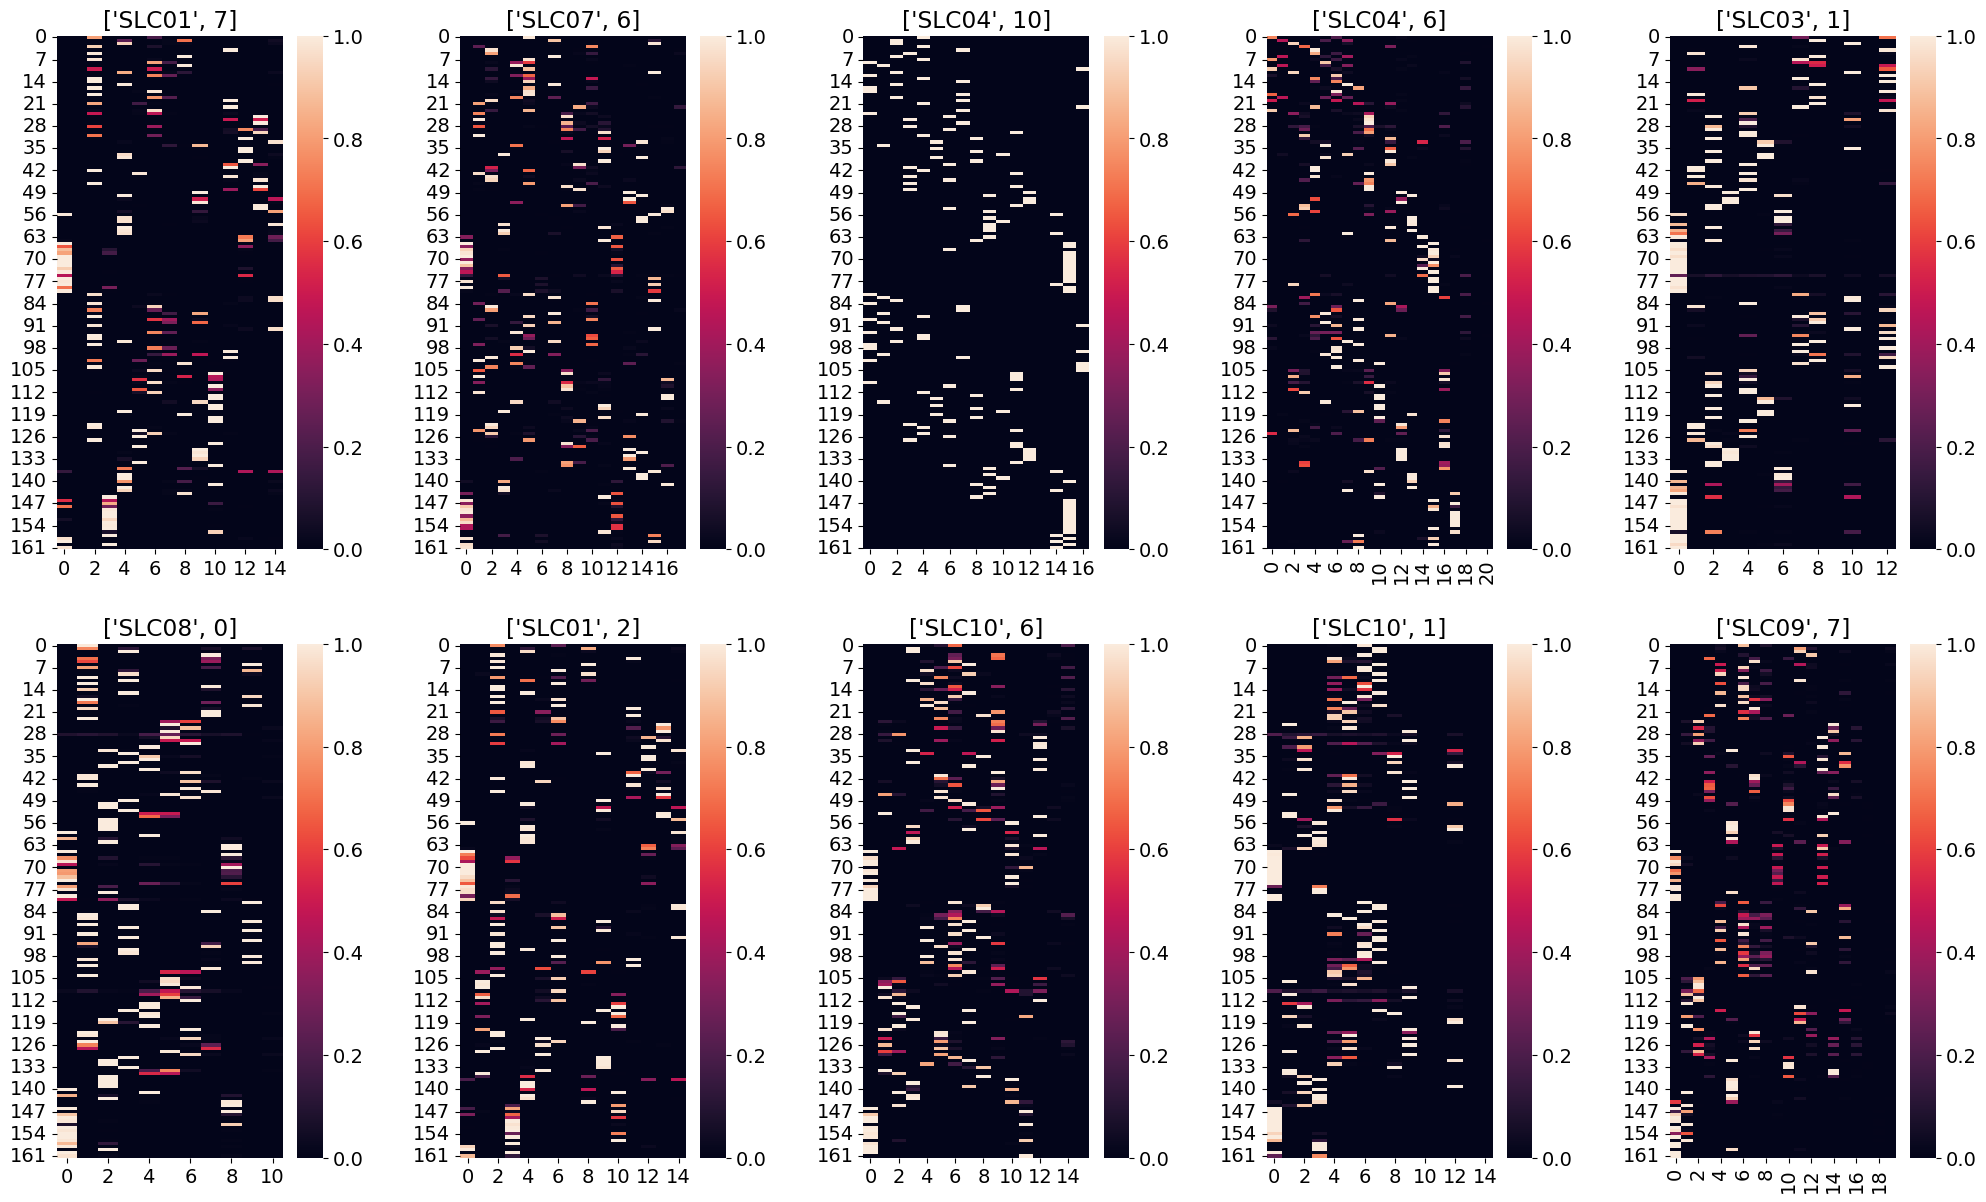

In [26]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
idxs = random.sample(indiv_dfs.index.to_list(), k=nrows*ncols)
for i, idx in enumerate(idxs):
    r, c = i // ncols, i % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    pi = indiv_dfs.iloc[idx]['pi']
    title = indiv_dfs.iloc[idx][['sub', 'mode_id']].to_list()
    sns.heatmap(pi, ax=ax)
    ax.set(title=f'{title}')

In [28]:
def get_membership_matrix(args, df):
    num_modes = len(df)
    num_comms = np.max(df['pi'].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0]['pi'].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df.iloc[idx_mode]['pi']
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M


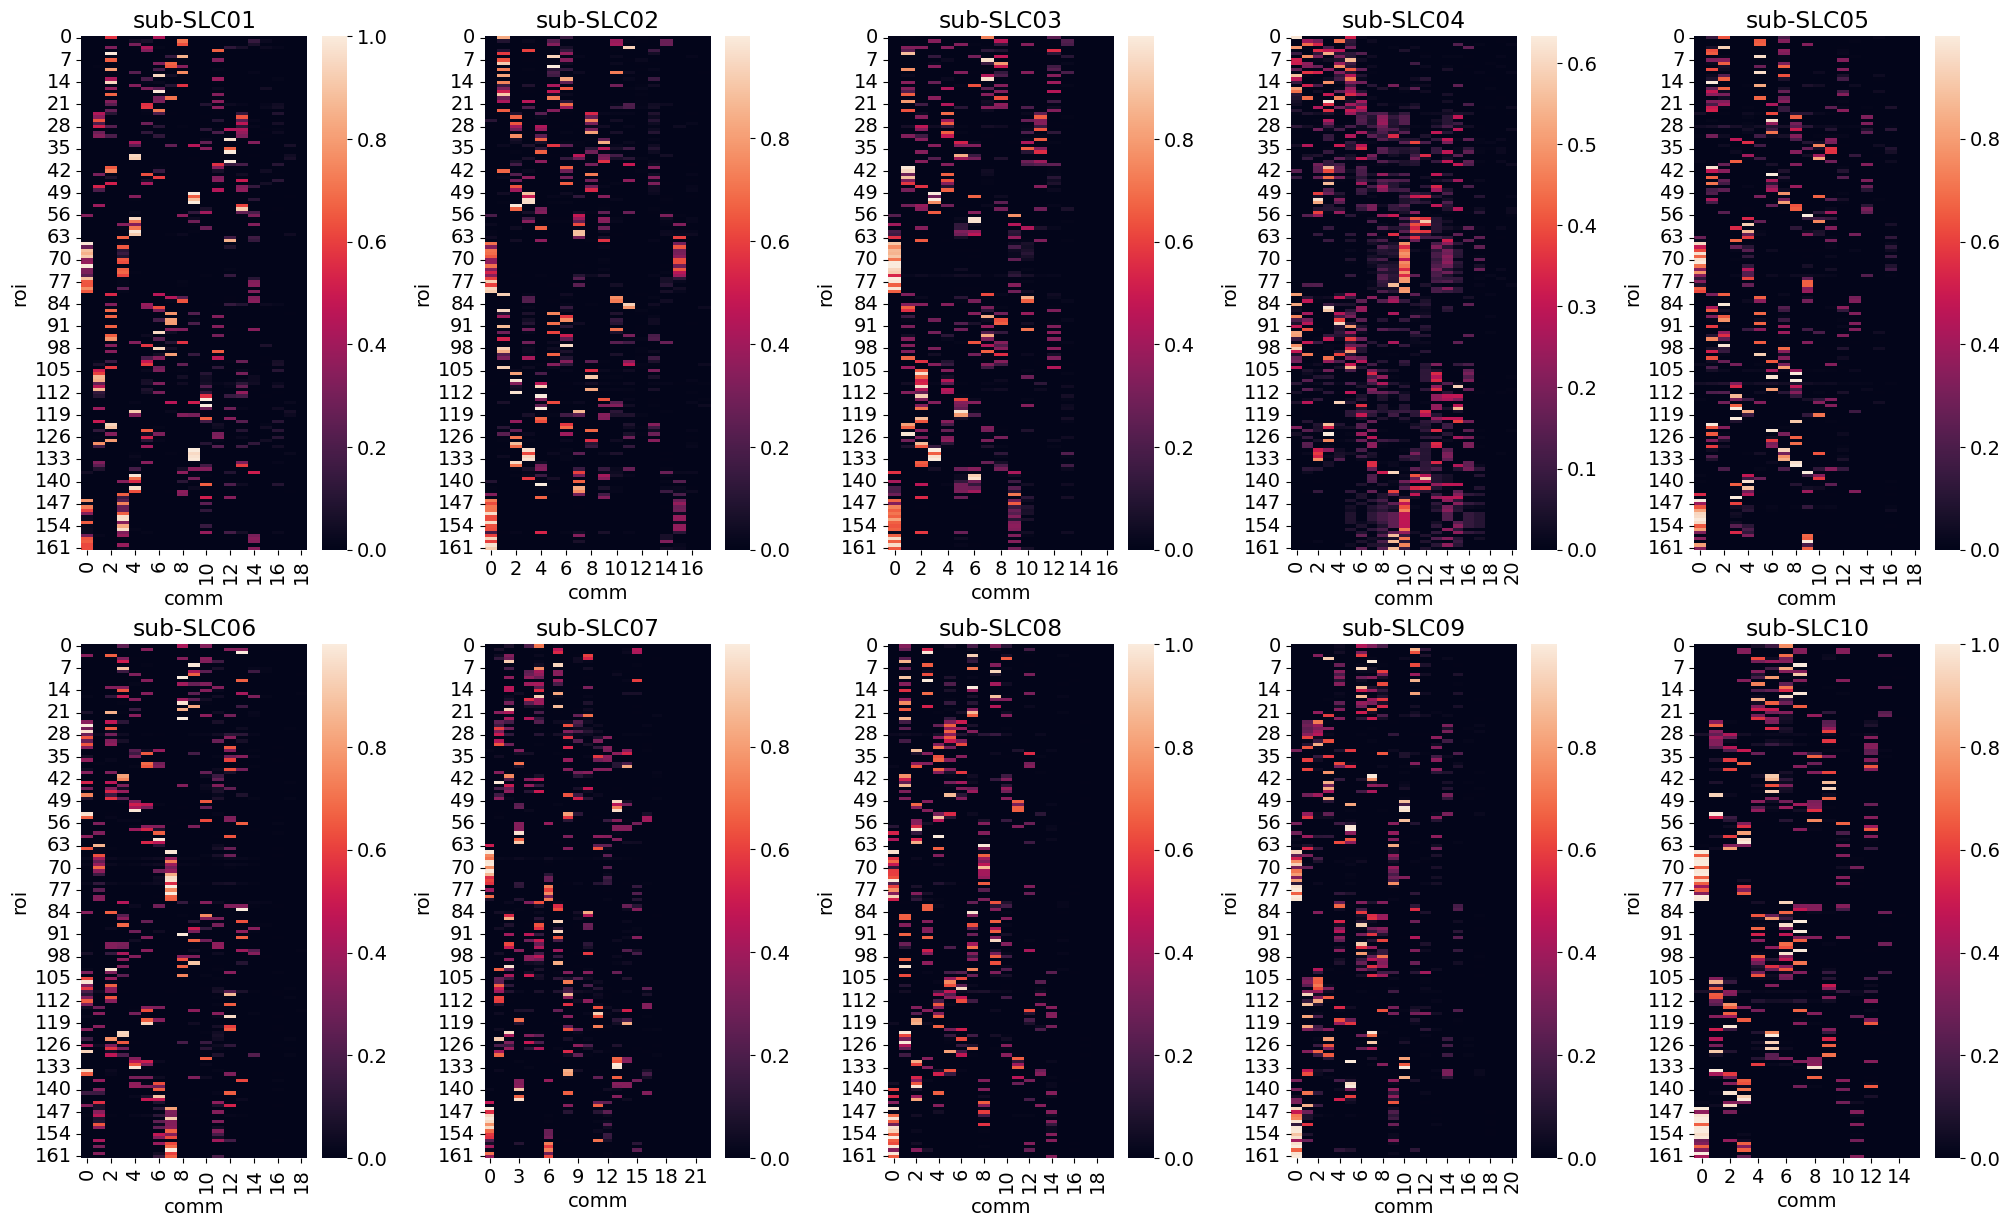

In [ ]:
# BEFORE GROUP LEVEL ALIGNMENT
Xs = []
for sub, group in indiv_dfs.groupby('sub'):
    M = get_membership_matrix(args, group)
    omegas = group['omega'].to_list()
    X = np.average(M, axis=1, weights=omegas)
    Xs += [X]

ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, X in enumerate(Xs):
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(X, ax=ax)
    ax.set(title=f'sub-SLC{idx+1:02d}', xlabel=f'comm', ylabel=f'roi')

---

In [39]:
def get_membership_matrix(args, df):
    num_modes = len(df)
    num_comms = np.max(df['pi_aligned'].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0]['pi_aligned'].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df.iloc[idx_mode]['pi_aligned']
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M

def reference_comms(args, X):
    X = np.concatenate(X, axis=-1)
    kmeans = KMeans(
        n_clusters=args.num_comms, 
        init='k-means++', n_init=50,
        random_state=args.SEED
    ).fit(X=X.T)
    print('found reference')
    return kmeans.cluster_centers_.T # num_rois x num_comms

def align_two_partitions(args, source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    D = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(D)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(args, X):
    comm_cntrs = reference_comms(args, X)
    
    for idx, comms in tqdm(enumerate(X)):
        (
            comms, 
            best_pi,
        ) = align_two_partitions(
            args, 
            source_comms=comms, 
            target_comms=comm_cntrs
        )
        X[idx] = comms * (comms > args.thresh)
        X[idx] = np.round(X[idx], decimals=3)
    return X

In [40]:
M = get_membership_matrix(args, indiv_dfs)
Xs = [np.squeeze(X) for X in np.split(M, M.shape[1], axis=1)]
args.thresh = 0.1
args.num_comms = Xs[0].shape[1]
Xs = align_partitions(args, Xs)
M = np.stack(Xs, axis=1)
print(M.shape)
indiv_dfs['pi_aligned'] = [np.squeeze(X) for X in np.split(M, M.shape[1], axis=1)]

found reference


101it [00:01, 88.91it/s]

(162, 101, 23)


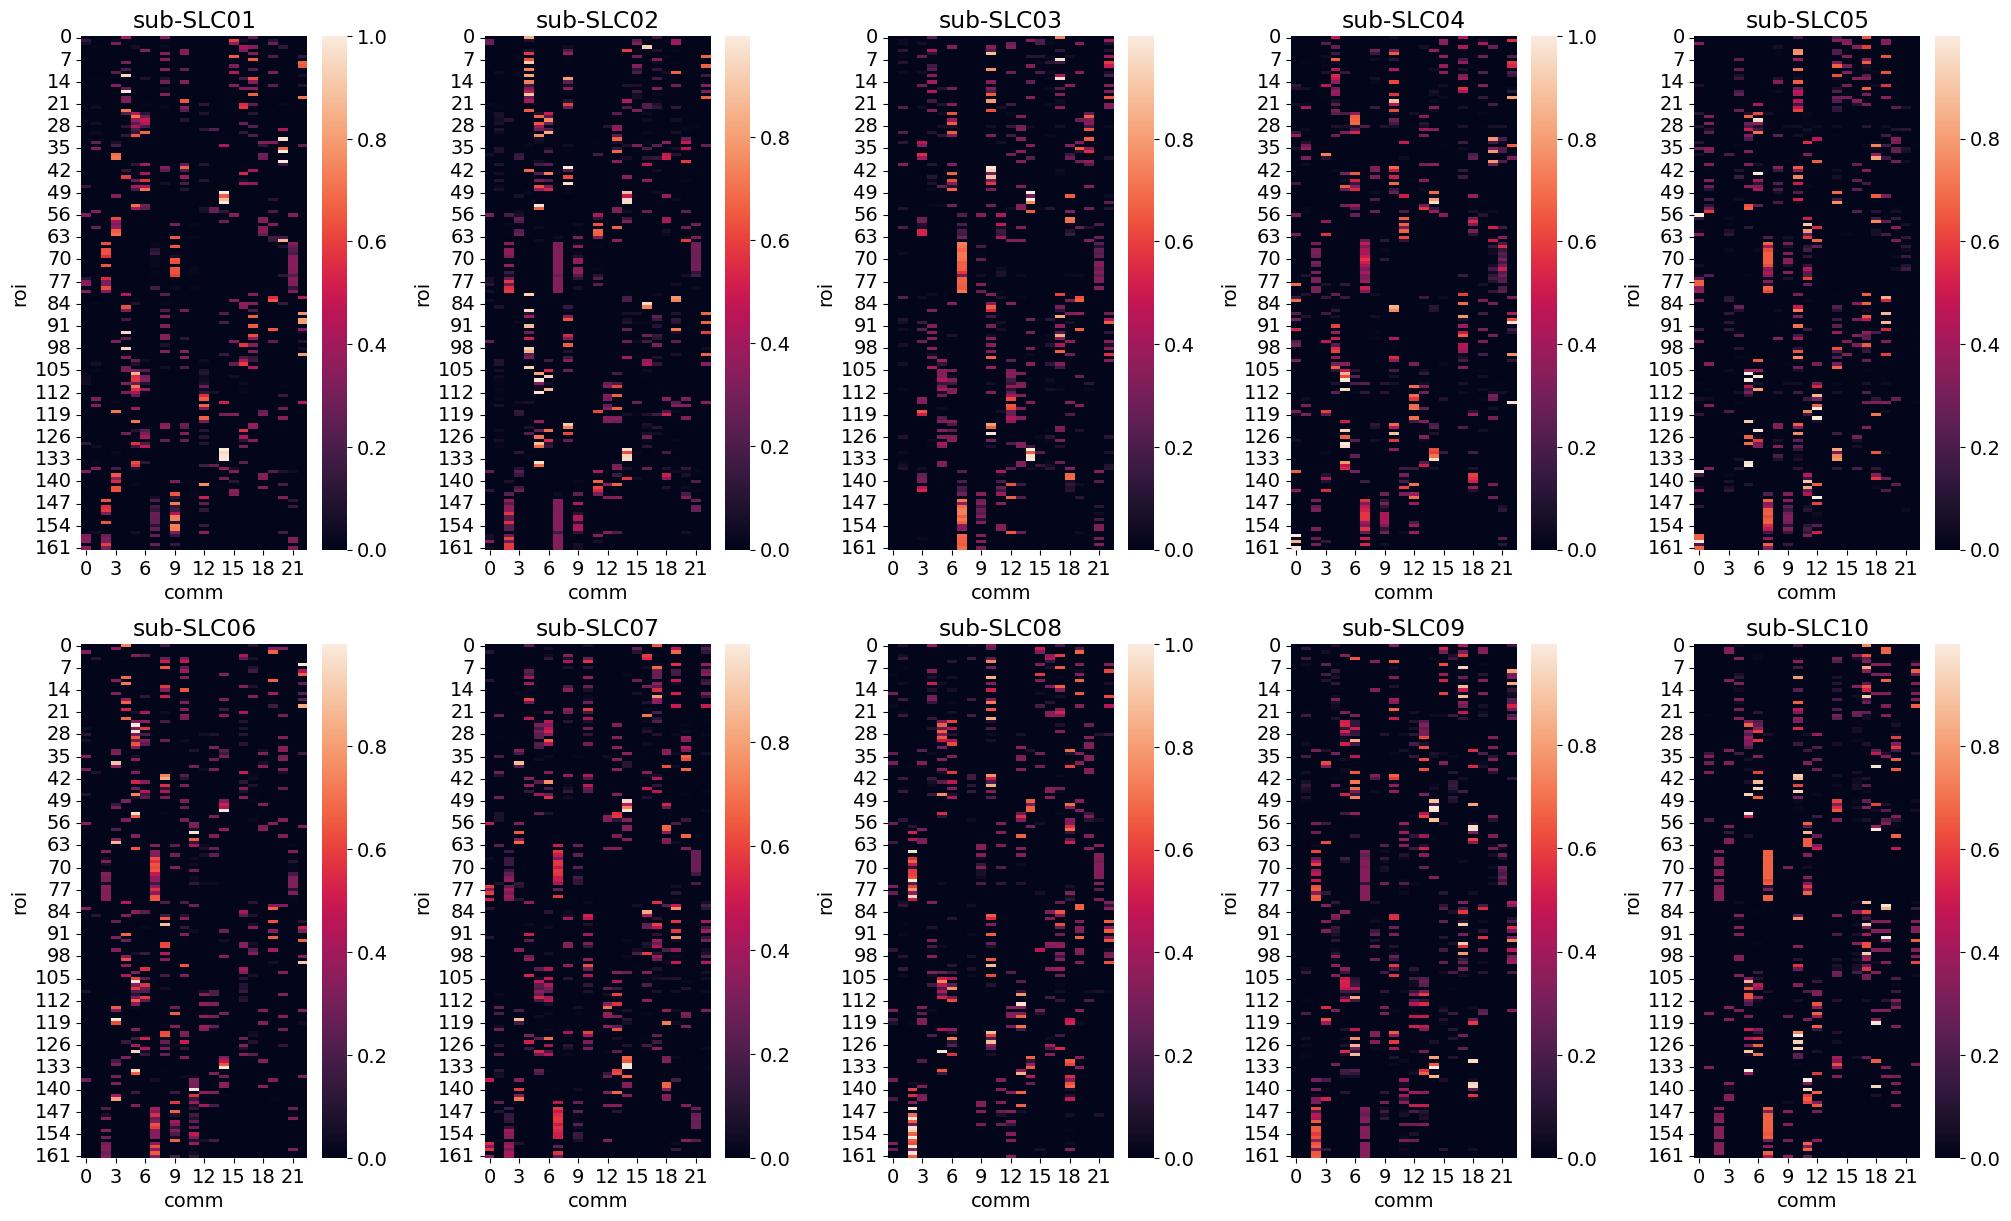

In [41]:
# AFTER GROUP LEVEL ALIGNMENT
Xs = []
for sub, group in indiv_dfs.groupby('sub'):
    M = get_membership_matrix(args, group)
    omegas = group['omega'].to_list()
    X = np.average(M, axis=1, weights=omegas)
    Xs += [X]

ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, X in enumerate(Xs):
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(X, ax=ax)
    ax.set(title=f'sub-SLC{idx+1:02d}', xlabel=f'comm', ylabel=f'roi')